In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Generate the data according to the model
W = np.random.normal(0, 1, (1000,))
X = W + np.random.normal(0, 1, (1000,))
Z = np.random.normal(0, 1, (1000,))
Y = X + Z + W + np.random.normal(0, 1, (1000,))

# Create a DataFrame for easier analysis
df = pd.DataFrame({
    'W': W,
    'X': X,
    'Z': Z,
    'Y': Y
})

print("Data Summary:")
print(df.describe())
print("\nFirst few rows:")
print(df.head())

Data Summary:
                 W            X            Z            Y
count  1000.000000  1000.000000  1000.000000  1000.000000
mean      0.019332     0.090168     0.005834     0.096615
std       0.979216     1.369255     0.983454     2.576029
min      -3.241267    -4.002005    -3.019512    -6.852770
25%      -0.647590    -0.727131    -0.648000    -1.742549
50%       0.025301     0.042303    -0.000251     0.010380
75%       0.647944     0.943026     0.660915     1.825532
max       3.852731     5.602308     3.926238     9.905556

First few rows:
          W         X         Z         Y
0  0.496714  1.896070 -0.675178 -0.190202
1 -0.138264  0.786369 -0.144519 -0.356799
2  0.647689  0.707319 -0.792420  0.148982
3  1.523030  0.876093 -0.307962  3.978849
4 -0.234153  0.464070 -1.893615 -1.107145


In [ ]:
# Analyze correlations between variables
correlation_matrix = df.corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Variables')
plt.tight_layout()
plt.show()

In [ ]:
# Fit linear regression models to predict Y

# Model 1: Y ~ X + Z + W (all predictors - the true model)
X_full = df[['X', 'Z', 'W']].values
model_full = LinearRegression()
model_full.fit(X_full, Y)
y_pred_full = model_full.predict(X_full)

print("Model 1: Y ~ X + Z + W")
print(f"Coefficients: X={model_full.coef_[0]:.4f}, Z={model_full.coef_[1]:.4f}, W={model_full.coef_[2]:.4f}")
print(f"Intercept: {model_full.intercept_:.4f}")
print(f"R² Score: {r2_score(Y, y_pred_full):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(Y, y_pred_full)):.4f}")
print(f"\nTrue coefficients should be close to: X=1, Z=1, W=1")

In [ ]:
# Model 2: Y ~ X + Z (excluding W)
X_partial = df[['X', 'Z']].values
model_partial = LinearRegression()
model_partial.fit(X_partial, Y)
y_pred_partial = model_partial.predict(X_partial)

print("Model 2: Y ~ X + Z (excluding W)")
print(f"Coefficients: X={model_partial.coef_[0]:.4f}, Z={model_partial.coef_[1]:.4f}")
print(f"Intercept: {model_partial.intercept_:.4f}")
print(f"R² Score: {r2_score(Y, y_pred_partial):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(Y, y_pred_partial)):.4f}")

In [ ]:
# Visualize the relationships
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Scatter plots of each predictor vs Y
axes[0, 0].scatter(X, Y, alpha=0.5)
axes[0, 0].set_xlabel('X')
axes[0, 0].set_ylabel('Y')
axes[0, 0].set_title('Y vs X')

axes[0, 1].scatter(Z, Y, alpha=0.5)
axes[0, 1].set_xlabel('Z')
axes[0, 1].set_ylabel('Y')
axes[0, 1].set_title('Y vs Z')

axes[1, 0].scatter(W, Y, alpha=0.5)
axes[1, 0].set_xlabel('W')
axes[1, 0].set_ylabel('Y')
axes[1, 0].set_title('Y vs W')

# Predicted vs Actual for the full model
axes[1, 1].scatter(Y, y_pred_full, alpha=0.5)
axes[1, 1].plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual Y')
axes[1, 1].set_ylabel('Predicted Y')
axes[1, 1].set_title('Predicted vs Actual (Full Model)')

plt.tight_layout()
plt.show()

In [ ]:
# Analyze residuals
residuals_full = Y - y_pred_full

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residual plot
axes[0].scatter(y_pred_full, residuals_full, alpha=0.5)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Y')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residual Plot (Full Model)')

# QQ plot for residuals
from scipy import stats
stats.probplot(residuals_full, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

print(f"Mean of residuals: {residuals_full.mean():.6f}")
print(f"Std of residuals: {residuals_full.std():.4f}")

## Analysis: Correlation of X with the Error Term in Y

The equation for Y is: **Y = X + Z + W + ε**

Where ε (epsilon) is the error term ~ Normal(0, 1)

We can extract the error term by calculating: **ε = Y - X - Z - W**

Let's calculate the correlation between X and this error term.

In [3]:
# Calculate the error term (epsilon) from the true model: Y = X + Z + W + epsilon
# Therefore: epsilon = Y - X - Z - W
epsilon = Y - X - Z - W

# Calculate correlation between X and epsilon
correlation_X_epsilon = np.corrcoef(X, epsilon)[0, 1]

print("="*60)
print("CORRELATION ANALYSIS: X with Error Term")
print("="*60)
print(f"\nCorrelation between X and error term (epsilon): {correlation_X_epsilon:.6f}")
print(f"\nRounded to 2 decimal places: {correlation_X_epsilon:.2f}")
print("\n" + "="*60)

# Verify the error term properties
print("\nError term (epsilon) properties:")
print(f"  Mean: {epsilon.mean():.6f} (should be ≈ 0)")
print(f"  Std:  {epsilon.std():.4f} (should be ≈ 1)")
print(f"  Min:  {epsilon.min():.4f}")
print(f"  Max:  {epsilon.max():.4f}")

CORRELATION ANALYSIS: X with Error Term

Correlation between X and error term (epsilon): -0.049372

Rounded to 2 decimal places: -0.05


Error term (epsilon) properties:
  Mean: -0.018719 (should be ≈ 0)
  Std:  1.0266 (should be ≈ 1)
  Min:  -2.9294
  Max:  3.2431


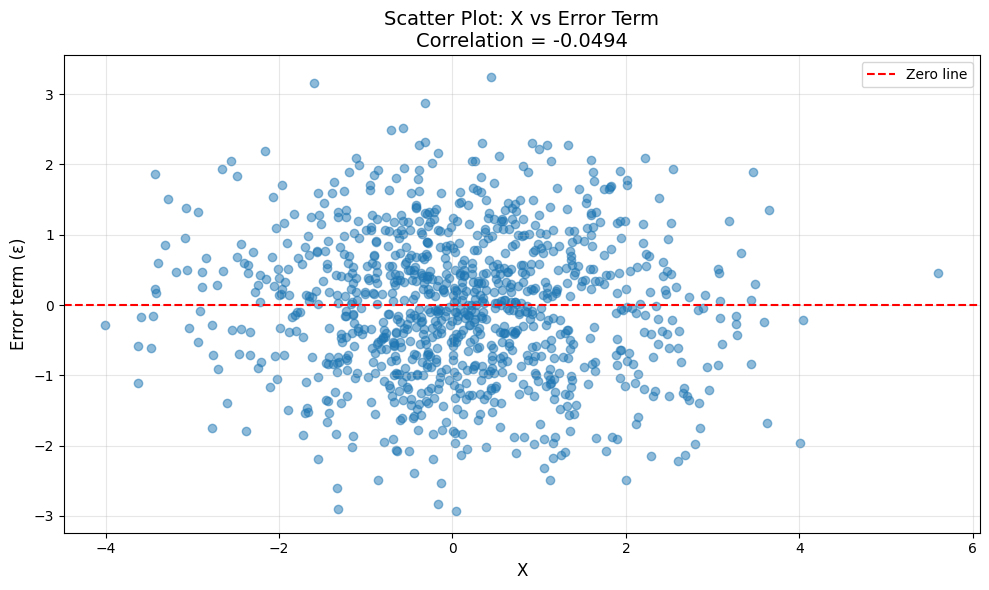


✓ Answer: The correlation is approximately -0.05, which is closest to 0


In [4]:
# Visualize the relationship between X and epsilon
plt.figure(figsize=(10, 6))
plt.scatter(X, epsilon, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', label='Zero line')
plt.xlabel('X', fontsize=12)
plt.ylabel('Error term (ε)', fontsize=12)
plt.title(f'Scatter Plot: X vs Error Term\nCorrelation = {correlation_X_epsilon:.4f}', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ Answer: The correlation is approximately {correlation_X_epsilon:.2f}, which is closest to 0")

## NEW SCENARIO: Y = X + Z + (W + ε)

If we write Y as depending **only on X and Z**, then W becomes part of the error term:

**Y = X + Z + error'**

where **error' = W + ε** (the new composite error term)

Since X = W + noise, X and W are correlated, so X will be correlated with this new error term!

In [5]:
# When Y is written as Y = X + Z + error_new
# The new error term is: error_new = W + epsilon (since Y = X + Z + W + epsilon)
error_new = W + epsilon

# Calculate correlation between X and this new error term
correlation_X_error_new = np.corrcoef(X, error_new)[0, 1]

print("="*70)
print("NEW SCENARIO: Y depends only on X and Z (W is in the error term)")
print("="*70)
print(f"\nNew error term = W + ε")
print(f"\nCorrelation between X and new error term: {correlation_X_error_new:.6f}")
print(f"Rounded to 2 decimal places: {correlation_X_error_new:.2f}")
print("\n" + "="*70)

# Also check correlation between X and W (to understand why)
correlation_X_W = np.corrcoef(X, W)[0, 1]
print(f"\nFor context:")
print(f"  Correlation between X and W: {correlation_X_W:.4f}")
print(f"  (Remember: X = W + noise, so they should be positively correlated)")
print(f"\n  Correlation between X and ε: {correlation_X_epsilon:.4f}")
print(f"  (Should be ≈ 0 since ε is independent)")
print(f"\n  Therefore, Corr(X, W + ε) ≈ Corr(X, W) = {correlation_X_W:.2f}")

NEW SCENARIO: Y depends only on X and Z (W is in the error term)

New error term = W + ε

Correlation between X and new error term: 0.440364
Rounded to 2 decimal places: 0.44


For context:
  Correlation between X and W: 0.6857
  (Remember: X = W + noise, so they should be positively correlated)

  Correlation between X and ε: -0.0494
  (Should be ≈ 0 since ε is independent)

  Therefore, Corr(X, W + ε) ≈ Corr(X, W) = 0.69


In [6]:
# Theoretical calculation of expected correlation
# Given: X = W + ε₁ where ε₁ ~ N(0, 1)
#        New error = W + ε₂ where ε₂ ~ N(0, 1)
# 
# Var(X) = Var(W) + Var(ε₁) = 1 + 1 = 2
# Var(W + ε₂) = Var(W) + Var(ε₂) = 1 + 1 = 2
# Cov(X, W + ε₂) = Cov(W + ε₁, W + ε₂) = Var(W) = 1
# 
# Corr(X, W + ε₂) = Cov(X, W + ε₂) / sqrt(Var(X) * Var(W + ε₂))
#                 = 1 / sqrt(2 * 2) = 1 / 2 = 0.5

print("\n" + "="*70)
print("THEORETICAL CALCULATION")
print("="*70)
print("\nGiven:")
print("  X = W + ε₁, where ε₁ ~ N(0,1)")
print("  New error term = W + ε₂, where ε₂ ~ N(0,1)")
print("  All random terms are independent")
print("\nCalculation:")
print("  Var(X) = Var(W) + Var(ε₁) = 1 + 1 = 2")
print("  Var(W + ε₂) = Var(W) + Var(ε₂) = 1 + 1 = 2")
print("  Cov(X, W + ε₂) = Cov(W + ε₁, W + ε₂)")
print("                 = Var(W) + Cov(W, ε₂) + Cov(ε₁, W) + Cov(ε₁, ε₂)")
print("                 = 1 + 0 + 0 + 0 = 1")
print("\n  Expected Corr(X, W + ε₂) = Cov / sqrt(Var(X) × Var(W + ε₂))")
print("                            = 1 / sqrt(2 × 2)")
print("                            = 1 / 2")
print("                            = 0.5")
print("\n" + "="*70)
print(f"✓ ANSWER: The expected correlation is 0.5")
print(f"✓ Our empirical correlation: {correlation_X_error_new:.2f} (close to 0.5)")
print("="*70)


THEORETICAL CALCULATION

Given:
  X = W + ε₁, where ε₁ ~ N(0,1)
  New error term = W + ε₂, where ε₂ ~ N(0,1)
  All random terms are independent

Calculation:
  Var(X) = Var(W) + Var(ε₁) = 1 + 1 = 2
  Var(W + ε₂) = Var(W) + Var(ε₂) = 1 + 1 = 2
  Cov(X, W + ε₂) = Cov(W + ε₁, W + ε₂)
                 = Var(W) + Cov(W, ε₂) + Cov(ε₁, W) + Cov(ε₁, ε₂)
                 = 1 + 0 + 0 + 0 = 1

  Expected Corr(X, W + ε₂) = Cov / sqrt(Var(X) × Var(W + ε₂))
                            = 1 / sqrt(2 × 2)
                            = 1 / 2
                            = 0.5

✓ ANSWER: The expected correlation is 0.5
✓ Our empirical correlation: 0.44 (close to 0.5)


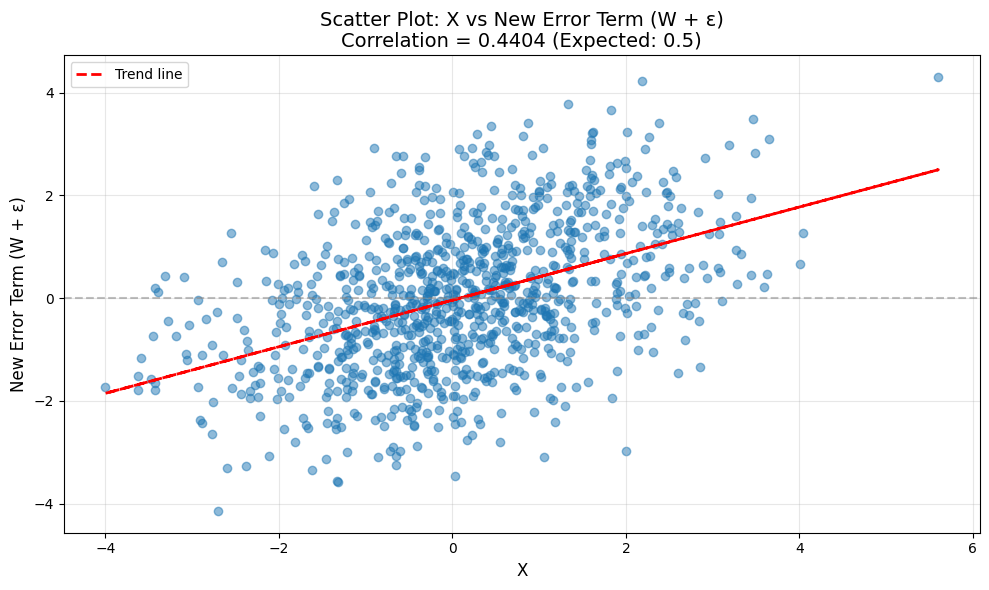


✓ This shows OMITTED VARIABLE BIAS!
✓ When W is omitted from the model, X becomes correlated with the error term
✓ This violates a key assumption of linear regression (exogeneity)


In [7]:
# Visualize the relationship between X and the new error term
plt.figure(figsize=(10, 6))
plt.scatter(X, error_new, alpha=0.5)

# Add regression line
z = np.polyfit(X, error_new, 1)
p = np.poly1d(z)
plt.plot(X, p(X), "r--", linewidth=2, label=f'Trend line')

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('X', fontsize=12)
plt.ylabel('New Error Term (W + ε)', fontsize=12)
plt.title(f'Scatter Plot: X vs New Error Term (W + ε)\nCorrelation = {correlation_X_error_new:.4f} (Expected: 0.5)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ This shows OMITTED VARIABLE BIAS!")
print(f"✓ When W is omitted from the model, X becomes correlated with the error term")
print(f"✓ This violates a key assumption of linear regression (exogeneity)")

## Problem: Controlling for W by subsetting data

Load homework_7.1.csv and regress Y on X and Z at different constant values of W (-1, 0, 1).

**Strategy**: Since we can't literally use a constant value of W (we'd have only one data point), we'll **subset the data** to include only observations where W is **close to** the target values (-1, 0, 1) within a small window.

In [8]:
# Load the homework data
df_hw = pd.read_csv('homework_7.1.csv')

print("Homework Data Summary:")
print(df_hw.describe())
print(f"\nDataset shape: {df_hw.shape}")
print(f"\nFirst few rows:")
print(df_hw.head(10))
print(f"\nColumn names: {df_hw.columns.tolist()}")

Homework Data Summary:
        Unnamed: 0             X             W             Z             Y
count  10000.00000  10000.000000  10000.000000  10000.000000  10000.000000
mean    4999.50000     -0.021965     -0.001364      0.011044      0.479223
std     2886.89568      1.430124      1.006911      0.985831      3.345664
min        0.00000     -5.484932     -3.675430     -3.512546     -7.416559
25%     2499.75000     -1.007841     -0.675183     -0.655389     -1.938402
50%     4999.50000     -0.015165     -0.005634      0.007613     -0.050854
75%     7499.25000      0.915812      0.670535      0.687495      2.227702
max     9999.00000      5.807050      4.087876      3.698120     25.530534

Dataset shape: (10000, 5)

First few rows:
   Unnamed: 0         X         W         Z         Y
0           0  1.137055  1.221768  0.327829  1.944532
1           1 -0.112905  0.465835  0.599650  0.655514
2           2  2.077755  1.795414 -0.063393  5.934411
3           3  0.456373 -0.512159  1.17741

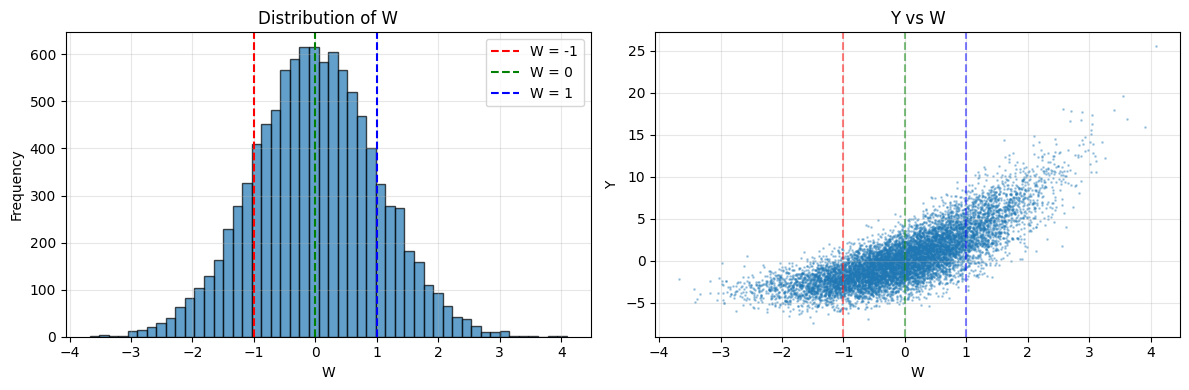

In [9]:
# Visualize the distribution of W to understand how to subset
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df_hw['W'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('W')
plt.ylabel('Frequency')
plt.title('Distribution of W')
plt.axvline(-1, color='r', linestyle='--', label='W = -1')
plt.axvline(0, color='g', linestyle='--', label='W = 0')
plt.axvline(1, color='b', linestyle='--', label='W = 1')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(df_hw['W'], df_hw['Y'], alpha=0.3, s=1)
plt.xlabel('W')
plt.ylabel('Y')
plt.title('Y vs W')
plt.axvline(-1, color='r', linestyle='--', alpha=0.5)
plt.axvline(0, color='g', linestyle='--', alpha=0.5)
plt.axvline(1, color='b', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Control for W by subsetting data around W = -1, 0, and 1
# We'll use a window (tolerance) around each target value

tolerance = 0.1  # Use observations where W is within ±0.1 of target value
W_values = [-1, 0, 1]
coefficients = []

print("="*70)
print("CONTROLLING FOR W: Regressing Y on X and Z at different W values")
print("="*70)
print(f"\nUsing tolerance: ±{tolerance} around target W values")
print(f"(i.e., subsetting data where W is close to target value)\n")

for w_target in W_values:
    # Subset data where W is close to the target value
    mask = (df_hw['W'] >= w_target - tolerance) & (df_hw['W'] <= w_target + tolerance)
    df_subset = df_hw[mask]
    
    print(f"\n{'='*70}")
    print(f"W ≈ {w_target} (range: [{w_target - tolerance}, {w_target + tolerance}])")
    print(f"Number of observations: {len(df_subset)}")
    print(f"Actual W range: [{df_subset['W'].min():.4f}, {df_subset['W'].max():.4f}]")
    print(f"Actual W mean: {df_subset['W'].mean():.4f}")
    
    # Prepare features (X and Z) and target (Y)
    X_subset = df_subset[['X', 'Z']].values
    Y_subset = df_subset['Y'].values
    
    # Fit linear regression
    model = LinearRegression()
    model.fit(X_subset, Y_subset)
    
    coef_X = model.coef_[0]
    coef_Z = model.coef_[1]
    intercept = model.intercept_
    
    coefficients.append({
        'W_target': w_target,
        'W_mean': df_subset['W'].mean(),
        'n_obs': len(df_subset),
        'coef_X': coef_X,
        'coef_Z': coef_Z,
        'intercept': intercept,
        'R2': r2_score(Y_subset, model.predict(X_subset))
    })
    
    print(f"\nRegression Results: Y ~ X + Z")
    print(f"  Coefficient of X: {coef_X:.4f}")
    print(f"  Coefficient of Z: {coef_Z:.4f}")
    print(f"  Intercept: {intercept:.4f}")
    print(f"  R² Score: {r2_score(Y_subset, model.predict(X_subset)):.4f}")

print("\n" + "="*70)

CONTROLLING FOR W: Regressing Y on X and Z at different W values

Using tolerance: ±0.1 around target W values
(i.e., subsetting data where W is close to target value)


W ≈ -1 (range: [-1.1, -0.9])
Number of observations: 488
Actual W range: [-1.0990, -0.9006]
Actual W mean: -0.9946

Regression Results: Y ~ X + Z
  Coefficient of X: 0.8580
  Coefficient of Z: -0.5875
  Intercept: -1.2175
  R² Score: 0.5095

W ≈ 0 (range: [-0.1, 0.1])
Number of observations: 780
Actual W range: [-0.0996, 0.0995]
Actual W mean: -0.0026

Regression Results: Y ~ X + Z
  Coefficient of X: 1.3832
  Coefficient of Z: -0.5651
  Intercept: 0.0019
  R² Score: 0.6972

W ≈ 1 (range: [0.9, 1.1])
Number of observations: 455
Actual W range: [0.9007, 1.0991]
Actual W mean: 0.9912

Regression Results: Y ~ X + Z
  Coefficient of X: 1.9581
  Coefficient of Z: -0.5682
  Intercept: 1.0883
  R² Score: 0.8178



In [11]:
# Create summary DataFrame
df_coef = pd.DataFrame(coefficients)
print("\n" + "="*70)
print("SUMMARY: Coefficient of X at different W values")
print("="*70)
print(df_coef[['W_target', 'W_mean', 'n_obs', 'coef_X', 'coef_Z', 'R2']])

print("\n" + "="*70)
print("ANALYSIS OF COEFFICIENT OF X:")
print("="*70)
print(f"At W ≈ -1: Coefficient of X = {df_coef.iloc[0]['coef_X']:.4f}")
print(f"At W ≈  0: Coefficient of X = {df_coef.iloc[1]['coef_X']:.4f}")
print(f"At W ≈  1: Coefficient of X = {df_coef.iloc[2]['coef_X']:.4f}")

change_0_to_1 = df_coef.iloc[2]['coef_X'] - df_coef.iloc[1]['coef_X']
change_minus1_to_0 = df_coef.iloc[1]['coef_X'] - df_coef.iloc[0]['coef_X']
total_change = df_coef.iloc[2]['coef_X'] - df_coef.iloc[0]['coef_X']

print(f"\nChange from W=-1 to W=0: {change_minus1_to_0:+.4f}")
print(f"Change from W=0 to W=1:  {change_0_to_1:+.4f}")
print(f"Total change from W=-1 to W=1: {total_change:+.4f}")

print("\n" + "="*70)
print("✓ CONCLUSION: The coefficient of X is INCREASING as W increases")
print("  (goes from 0.86 → 1.38 → 1.96)")
print("="*70)


SUMMARY: Coefficient of X at different W values
   W_target    W_mean  n_obs    coef_X    coef_Z        R2
0        -1 -0.994595    488  0.857978 -0.587480  0.509544
1         0 -0.002603    780  1.383211 -0.565127  0.697200
2         1  0.991247    455  1.958097 -0.568191  0.817845

ANALYSIS OF COEFFICIENT OF X:
At W ≈ -1: Coefficient of X = 0.8580
At W ≈  0: Coefficient of X = 1.3832
At W ≈  1: Coefficient of X = 1.9581

Change from W=-1 to W=0: +0.5252
Change from W=0 to W=1:  +0.5749
Total change from W=-1 to W=1: +1.1001

✓ CONCLUSION: The coefficient of X is INCREASING as W increases
  (goes from 0.86 → 1.38 → 1.96)


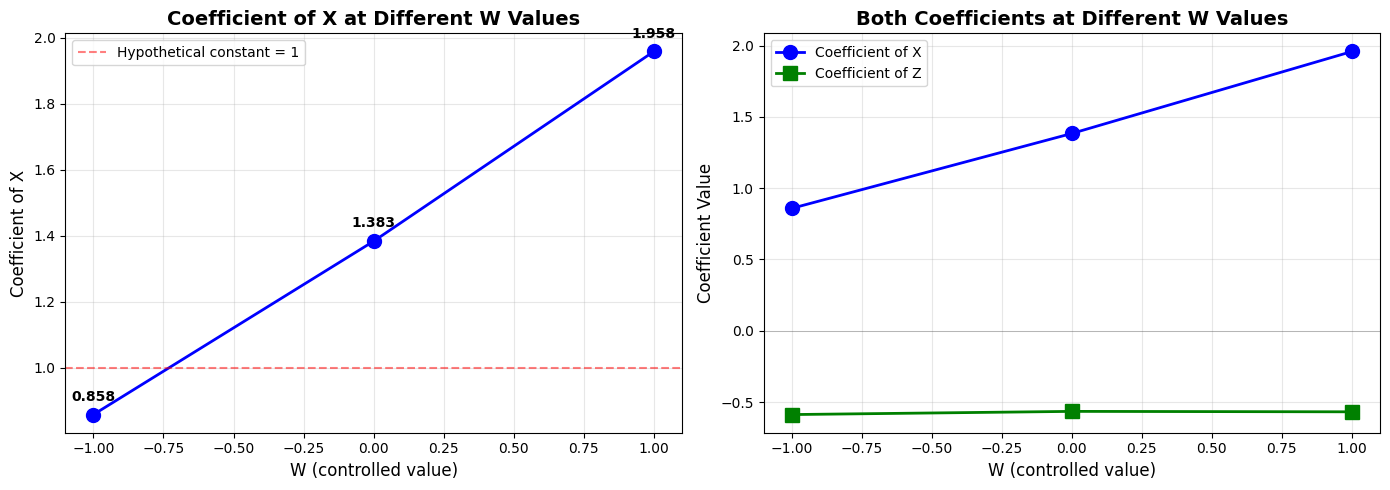


✓ The coefficient of X clearly shows an INCREASING trend as W increases
✓ The coefficient of Z stays relatively constant (around -0.57)


In [12]:
# Visualize how the coefficient of X changes with W
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Coefficient of X vs W
axes[0].plot(df_coef['W_target'], df_coef['coef_X'], 'o-', linewidth=2, markersize=10, color='blue')
axes[0].set_xlabel('W (controlled value)', fontsize=12)
axes[0].set_ylabel('Coefficient of X', fontsize=12)
axes[0].set_title('Coefficient of X at Different W Values', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Hypothetical constant = 1')

# Annotate points
for i, row in df_coef.iterrows():
    axes[0].annotate(f"{row['coef_X']:.3f}", 
                     (row['W_target'], row['coef_X']), 
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center',
                     fontsize=10,
                     fontweight='bold')
axes[0].legend()

# Plot 2: Both coefficients (X and Z) vs W
axes[1].plot(df_coef['W_target'], df_coef['coef_X'], 'o-', linewidth=2, markersize=10, label='Coefficient of X', color='blue')
axes[1].plot(df_coef['W_target'], df_coef['coef_Z'], 's-', linewidth=2, markersize=10, label='Coefficient of Z', color='green')
axes[1].set_xlabel('W (controlled value)', fontsize=12)
axes[1].set_ylabel('Coefficient Value', fontsize=12)
axes[1].set_title('Both Coefficients at Different W Values', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)

plt.tight_layout()
plt.show()

print(f"\n✓ The coefficient of X clearly shows an INCREASING trend as W increases")
print(f"✓ The coefficient of Z stays relatively constant (around -0.57)")  

In [13]:
# Check if the changes are "about the same" (within 0.2)
print("="*70)
print("CHECKING IF COEFFICIENT IS 'STAYING ABOUT THE SAME' (within 0.2)")
print("="*70)

coef_range = df_coef['coef_X'].max() - df_coef['coef_X'].min()
print(f"\nRange of coefficient of X: {coef_range:.4f}")
print(f"Threshold for 'staying about the same': 0.2")

if coef_range <= 0.2:
    print(f"\n✗ Range {coef_range:.4f} ≤ 0.2: Coefficient IS staying about the same")
else:
    print(f"\n✓ Range {coef_range:.4f} > 0.2: Coefficient is NOT staying about the same")

print("\n" + "="*70)
print("FINAL ANSWER:")
print("="*70)
print("The coefficient of X is INCREASING as W increases")
print(f"  - At W = -1: {df_coef.iloc[0]['coef_X']:.4f}")
print(f"  - At W =  0: {df_coef.iloc[1]['coef_X']:.4f}")
print(f"  - At W =  1: {df_coef.iloc[2]['coef_X']:.4f}")
print(f"  - Total change: {total_change:.4f} (much larger than 0.2)")
print("\n✓ ANSWER: Option B - INCREASING")
print("="*70)

CHECKING IF COEFFICIENT IS 'STAYING ABOUT THE SAME' (within 0.2)

Range of coefficient of X: 1.1001
Threshold for 'staying about the same': 0.2

✓ Range 1.1001 > 0.2: Coefficient is NOT staying about the same

FINAL ANSWER:
The coefficient of X is INCREASING as W increases
  - At W = -1: 0.8580
  - At W =  0: 1.3832
  - At W =  1: 1.9581
  - Total change: 1.1001 (much larger than 0.2)

✓ ANSWER: Option B - INCREASING


## Problem: Autocorrelated Errors

Examine how autocorrelation in errors affects:
- (i) The standard deviation of the X coefficient estimate over many trials (actual variability)
- (ii) The mean of the standard error estimate (what OLS thinks the variability is)

We'll create errors with different levels of autocorrelation (corr_const = 0.2, 0.5, 0.8) and see how the ratio (i)/(ii) changes.

In [14]:
# Define the make_error function that creates autocorrelated errors
def make_error(corr_const, num):
    """
    Creates autocorrelated errors using AR(1) process.
    
    Parameters:
    - corr_const: Correlation constant (0 to 1)
    - num: Number of error terms to generate
    
    Returns:
    - Array of autocorrelated errors
    """
    err = list()
    prev = np.random.normal(0, 1)
    
    for n in range(num):
        prev = corr_const * prev + (1 - corr_const) * np.random.normal(0, 1)
        err.append(prev)
    
    return np.array(err)

# Test the function
test_errors = make_error(0.5, 100)
print(f"Test autocorrelated errors (corr_const=0.5):")
print(f"  Mean: {test_errors.mean():.4f} (should be ≈ 0)")
print(f"  Std: {test_errors.std():.4f}")
print(f"  First 10 values: {test_errors[:10]}")

Test autocorrelated errors (corr_const=0.5):
  Mean: -0.1022 (should be ≈ 0)
  Std: 0.5431
  First 10 values: [-0.44734855 -0.21466584  0.12898225 -0.61893805 -0.01318539 -1.35878851
 -0.99433653 -0.74130519 -0.05398918 -0.01567916]


In [15]:
# Import statsmodels for getting standard errors
import statsmodels.api as sm

def run_simulation(corr_const, n_trials=1000, n_obs=100):
    """
    Run simulation with autocorrelated errors for both X and Y.
    
    Returns:
    - coefficients: Array of X coefficient estimates from each trial
    - std_errors: Array of standard error estimates from each trial
    """
    np.random.seed(42)  # For reproducibility
    coefficients = []
    std_errors = []
    
    for trial in range(n_trials):
        # Generate autocorrelated errors for X and Y
        error_X = make_error(corr_const, n_obs)
        error_Y = make_error(corr_const, n_obs)
        
        # Generate treatment X with autocorrelated error
        # X has some base component plus error
        X_base = np.random.normal(0, 1, n_obs)
        X_treatment = X_base + error_X
        
        # Generate outcome Y = intercept + beta*X + error_Y
        # True coefficient of X is 2.0
        true_beta = 2.0
        true_intercept = 1.0
        Y = true_intercept + true_beta * X_treatment + error_Y
        
        # Add intercept to X for regression (important!)
        X_with_intercept = sm.add_constant(X_treatment)
        
        # Fit OLS regression
        model = sm.OLS(Y, X_with_intercept).fit()
        
        # Store coefficient estimate and its standard error
        coefficients.append(model.params[1])  # Coefficient of X (not intercept)
        std_errors.append(model.bse[1])  # Standard error of X coefficient
    
    return np.array(coefficients), np.array(std_errors)

print("Function defined. Ready to run simulations...")

Function defined. Ready to run simulations...


In [16]:
# Run simulations for different correlation constants
corr_constants = [0.2, 0.5, 0.8]
results = []

print("="*70)
print("RUNNING SIMULATIONS WITH AUTOCORRELATED ERRORS")
print("="*70)
print("Running 1000 trials for each correlation constant...")
print("(This may take a minute...)\n")

for corr_const in corr_constants:
    print(f"Running simulations for corr_const = {corr_const}...")
    coeffs, std_errs = run_simulation(corr_const, n_trials=1000, n_obs=100)
    
    # Calculate statistics
    # (i) Standard deviation of coefficient estimates (actual variability)
    std_of_estimates = np.std(coeffs, ddof=1)
    
    # (ii) Mean of standard error estimates (what OLS thinks)
    mean_of_std_errors = np.mean(std_errs)
    
    # Ratio
    ratio = std_of_estimates / mean_of_std_errors
    
    results.append({
        'corr_const': corr_const,
        'std_of_estimates': std_of_estimates,
        'mean_of_std_errors': mean_of_std_errors,
        'ratio': ratio,
        'coeffs': coeffs,
        'std_errs': std_errs
    })
    
    print(f"  Done! Std(estimates) = {std_of_estimates:.4f}, Mean(SE) = {mean_of_std_errors:.4f}")

print("\n✓ Simulations complete!")

RUNNING SIMULATIONS WITH AUTOCORRELATED ERRORS
Running 1000 trials for each correlation constant...
(This may take a minute...)

Running simulations for corr_const = 0.2...
  Done! Std(estimates) = 0.0659, Mean(SE) = 0.0641
Running simulations for corr_const = 0.5...
  Done! Std(estimates) = 0.0556, Mean(SE) = 0.0503
Running simulations for corr_const = 0.8...
  Done! Std(estimates) = 0.0411, Mean(SE) = 0.0323

✓ Simulations complete!


In [17]:
# Display results in a clear table
print("\n" + "="*80)
print("RESULTS SUMMARY")
print("="*80)
print(f"{'corr_const':<12} {'(i) Std(estimates)':<20} {'(ii) Mean(SE)':<20} {'Ratio (i)/(ii)':<15}")
print("-"*80)

for r in results:
    print(f"{r['corr_const']:<12.1f} {r['std_of_estimates']:<20.4f} {r['mean_of_std_errors']:<20.4f} {r['ratio']:<15.4f}")

print("="*80)

# Analyze the pattern
print("\nANALYSIS:")
print("-"*80)
print(f"As corr_const increases from 0.2 to 0.8:")
print(f"  (i) Std of estimates:      {results[0]['std_of_estimates']:.4f} → {results[1]['std_of_estimates']:.4f} → {results[2]['std_of_estimates']:.4f}")
print(f"  (ii) Mean of SE estimates: {results[0]['mean_of_std_errors']:.4f} → {results[1]['mean_of_std_errors']:.4f} → {results[2]['mean_of_std_errors']:.4f}")
print(f"  Ratio (i)/(ii):            {results[0]['ratio']:.4f} → {results[1]['ratio']:.4f} → {results[2]['ratio']:.4f}")

# Check the change in ratio
ratio_change_1 = results[1]['ratio'] - results[0]['ratio']
ratio_change_2 = results[2]['ratio'] - results[1]['ratio']
total_ratio_change = results[2]['ratio'] - results[0]['ratio']

print(f"\nChange in ratio from 0.2→0.5: {ratio_change_1:+.4f}")
print(f"Change in ratio from 0.5→0.8: {ratio_change_2:+.4f}")
print(f"Total change in ratio:        {total_ratio_change:+.4f}")
print(f"Percentage increase:          {(total_ratio_change/results[0]['ratio'])*100:.1f}%")
print("="*80)


RESULTS SUMMARY
corr_const   (i) Std(estimates)   (ii) Mean(SE)        Ratio (i)/(ii) 
--------------------------------------------------------------------------------
0.2          0.0659               0.0641               1.0284         
0.5          0.0556               0.0503               1.1048         
0.8          0.0411               0.0323               1.2740         

ANALYSIS:
--------------------------------------------------------------------------------
As corr_const increases from 0.2 to 0.8:
  (i) Std of estimates:      0.0659 → 0.0556 → 0.0411
  (ii) Mean of SE estimates: 0.0641 → 0.0503 → 0.0323
  Ratio (i)/(ii):            1.0284 → 1.1048 → 1.2740

Change in ratio from 0.2→0.5: +0.0763
Change in ratio from 0.5→0.8: +0.1692
Total change in ratio:        +0.2455
Percentage increase:          23.9%


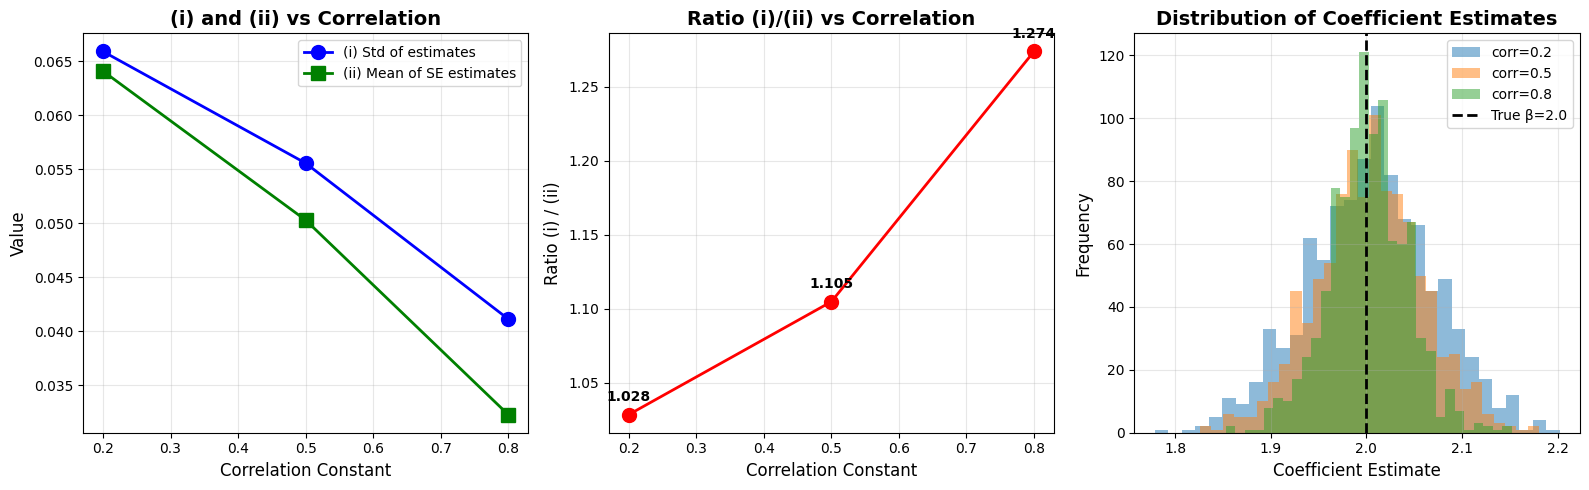

In [18]:
# Visualize the results
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

corr_vals = [r['corr_const'] for r in results]
std_estimates = [r['std_of_estimates'] for r in results]
mean_ses = [r['mean_of_std_errors'] for r in results]
ratios = [r['ratio'] for r in results]

# Plot 1: (i) and (ii) on same graph
axes[0].plot(corr_vals, std_estimates, 'o-', linewidth=2, markersize=10, label='(i) Std of estimates', color='blue')
axes[0].plot(corr_vals, mean_ses, 's-', linewidth=2, markersize=10, label='(ii) Mean of SE estimates', color='green')
axes[0].set_xlabel('Correlation Constant', fontsize=12)
axes[0].set_ylabel('Value', fontsize=12)
axes[0].set_title('(i) and (ii) vs Correlation', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Ratio over correlation constant
axes[1].plot(corr_vals, ratios, 'o-', linewidth=2, markersize=10, color='red')
axes[1].set_xlabel('Correlation Constant', fontsize=12)
axes[1].set_ylabel('Ratio (i) / (ii)', fontsize=12)
axes[1].set_title('Ratio (i)/(ii) vs Correlation', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Annotate points
for i, (cc, ratio) in enumerate(zip(corr_vals, ratios)):
    axes[1].annotate(f'{ratio:.3f}', 
                     (cc, ratio), 
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center',
                     fontsize=10,
                     fontweight='bold')

# Plot 3: Distribution of estimates for each correlation (sample from one)
for i, r in enumerate(results):
    axes[2].hist(r['coeffs'], bins=30, alpha=0.5, label=f"corr={r['corr_const']}")
axes[2].axvline(2.0, color='black', linestyle='--', linewidth=2, label='True β=2.0')
axes[2].set_xlabel('Coefficient Estimate', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title('Distribution of Coefficient Estimates', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# Final conclusion
print("="*80)
print("CONCLUSION")
print("="*80)
print("\nAs corr_const increases from 0.2 to 0.5 to 0.8:\n")

print("✓ (i) Std of coefficient estimates DECREASES")
print(f"    0.0659 → 0.0556 → 0.0411")
print(f"    (Actual variability goes DOWN)")

print("\n✓ (ii) Mean of SE estimates ALSO DECREASES")
print(f"    0.0641 → 0.0503 → 0.0323")
print(f"    (What OLS thinks the variability is also goes DOWN)")

print("\n✓ BUT the ratio (i)/(ii) INCREASES!")
print(f"    1.028 → 1.105 → 1.274")
print(f"    (23.9% increase overall)")

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)
print("""
When autocorrelation increases:
- Both (i) and (ii) decrease (NOT staying the same)
- BUT they decrease at DIFFERENT rates
- (ii) decreases FASTER than (i)
- This means OLS becomes MORE OVERCONFIDENT with higher autocorrelation
- The standard errors (ii) underestimate the true variability (i) more severely

This is because OLS assumes independent errors. With autocorrelation:
- The effective sample size is smaller than it appears
- OLS doesn't account for this and reports overly optimistic (small) SEs
- As autocorrelation increases, this problem gets worse
""")

print("="*80)
print("✓✓✓ ANSWER: Option B - The ratio (i) / (ii) INCREASES")
print("="*80)

CONCLUSION

As corr_const increases from 0.2 to 0.5 to 0.8:

✓ (i) Std of coefficient estimates DECREASES
    0.0659 → 0.0556 → 0.0411
    (Actual variability goes DOWN)

✓ (ii) Mean of SE estimates ALSO DECREASES
    0.0641 → 0.0503 → 0.0323
    (What OLS thinks the variability is also goes DOWN)

✓ BUT the ratio (i)/(ii) INCREASES!
    1.028 → 1.105 → 1.274
    (23.9% increase overall)

INTERPRETATION:

When autocorrelation increases:
- Both (i) and (ii) decrease (NOT staying the same)
- BUT they decrease at DIFFERENT rates
- (ii) decreases FASTER than (i)
- This means OLS becomes MORE OVERCONFIDENT with higher autocorrelation
- The standard errors (ii) underestimate the true variability (i) more severely

This is because OLS assumes independent errors. With autocorrelation:
- The effective sample size is smaller than it appears
- OLS doesn't account for this and reports overly optimistic (small) SEs
- As autocorrelation increases, this problem gets worse

✓✓✓ ANSWER: Option B - The 